# PanClassif Analysis with MAGIC smoothing

In [1]:
# import panclassif as pc
import pandas as pd
import numpy as np
from panclassif import dataProcess, featSelect, upsampled, binary_merge, multi_merge, classification
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, matthews_corrcoef, balanced_accuracy_score, f1_score, fbeta_score, recall_score, precision_score, average_precision_score, confusion_matrix
import optuna
from sklearn.exceptions import ConvergenceWarning
import warnings
import logging
import optuna
from tqdm import tqdm
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning, message="OptunaSearchCV is experimental")
logging.getLogger('optuna').setLevel(logging.WARNING)
optuna.logging.set_verbosity(optuna.logging.ERROR)
optuna.logging.disable_default_handler()

### Custom functions for Optuna optimization

In [2]:
def objective(trial, X_train, y_train, X_val, y_val, classification_type):
    # Suggest values for hyperparameters
    n_estimators = trial.suggest_int("n_estimators", 10, 500, log=True)
    max_depth = trial.suggest_int("max_depth", 2, 300)

    # Create and fit random forest model
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        random_state=42
    )
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_val)

    if classification_type == 'bin':
        average = 'binary'
    else:
        average = 'macro'

    # Calculate metrics
    mcc = matthews_corrcoef(y_val, y_pred)
    balanced_acc = balanced_accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred, average=average)
    f2 = fbeta_score(y_val, y_pred, beta=2, average=average)
    recall = recall_score(y_val, y_pred, average=average)
    precision = precision_score(y_val, y_pred, average=average)
    
    if classification_type == 'bin':
        avg_precision = average_precision_score(y_val, model.predict_proba(X_val)[:, 1])
        tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
        specificity = tn / (tn + fp)
        npv = tn / (tn + fn)
    else:
        avg_precision = np.nan  # Not applicable for multiclass
        specificity = np.nan
        npv = np.nan

    return -mcc

In [3]:
def perform_cv(X, y, classification_type, rounds=10, n_trials=25):
    # Initialize dictionaries and lists to store scores and hyperparameters
    cv_scores = {'accuracy': [], 'mcc': [], 'balanced_accuracy': [], 'f1_score': [], 'f2_score': [],
                 'recall': [], 'precision': [], 'average_precision': [], 'specificity': [], 'npv': []}
    cv_params = []

    # Generate random states for 10 rounds of CV
    np.random.seed(42)
    seeds = [np.random.randint(1, 1000) for _ in range(rounds)]
    print("Generated Seeds:", seeds)

    # Perform cross-validation for each round
    for round_idx in range(rounds):
        print(f"Round {round_idx + 1}")

        cv_random_state = seeds[round_idx]
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=cv_random_state)

        # Initialize lists to store fold results
        fold_accuracies = []
        fold_mccs = []
        fold_balanced_accs = []
        fold_f1_scores = []
        fold_f2_scores = []
        fold_recalls = []
        fold_precisions = []
        fold_avg_precisions = []
        fold_specificities = []
        fold_npvs = []
        fold_params = []

        for fold_idx, (train_idx, val_idx) in enumerate(tqdm(cv.split(X, y), desc=f"CV Progress (Round {round_idx + 1})")):
            print(f"  Fold {fold_idx + 1}")
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]

            # Inner cross-validation
            study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=cv_random_state))
            study.optimize(lambda trial: objective(trial, X_train, y_train, X_val, y_val, classification_type), n_trials=n_trials, show_progress_bar=True)

            # Store the best trial and parameters
            best_trial = study.best_trial
            best_params = best_trial.params

            # Train the model with the best hyperparameters on the training data
            model = RandomForestClassifier(
                n_estimators=best_params['n_estimators'],
                max_depth=best_params['max_depth'],
                random_state=42,
            )
            model.fit(X_train, y_train)

            # Evaluate on the validation set
            y_pred = model.predict(X_val)
            accuracy = accuracy_score(y_val, y_pred)
            mcc = matthews_corrcoef(y_val, y_pred)
            balanced_acc = balanced_accuracy_score(y_val, y_pred)
            f1 = f1_score(y_val, y_pred, average='macro')
            f2 = fbeta_score(y_val, y_pred, beta=2, average='macro')
            recall = recall_score(y_val, y_pred, average='macro')
            precision = precision_score(y_val, y_pred, average='macro')
            
            if classification_type == 'bin':
                avg_precision = average_precision_score(y_val, model.predict_proba(X_val)[:, 1])
                tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
                specificity = tn / (tn + fp)
                npv = tn / (tn + fn)
            else:
                avg_precision = np.nan  # Not applicable for multiclass
                specificity = np.nan
                npv = np.nan

            # Store fold results
            fold_accuracies.append(accuracy)
            fold_mccs.append(mcc)
            fold_balanced_accs.append(balanced_acc)
            fold_f1_scores.append(f1)
            fold_f2_scores.append(f2)
            fold_recalls.append(recall)
            fold_precisions.append(precision)
            fold_avg_precisions.append(avg_precision)
            fold_specificities.append(specificity)
            fold_npvs.append(npv)
            fold_params.append(best_params)

        # Calculate median scores for the round
        median_accuracy = np.median(fold_accuracies)
        median_mcc = np.median(fold_mccs)

        # Store round results
        cv_scores['accuracy'].append(median_accuracy)
        cv_scores['mcc'].append(median_mcc)
        cv_scores['balanced_accuracy'].append(np.median(fold_balanced_accs))
        cv_scores['f1_score'].append(np.median(fold_f1_scores))
        cv_scores['f2_score'].append(np.median(fold_f2_scores))
        cv_scores['recall'].append(np.median(fold_recalls))
        cv_scores['precision'].append(np.median(fold_precisions))
        cv_scores['average_precision'].append(np.median(fold_avg_precisions))
        cv_scores['specificity'].append(np.median(fold_specificities))
        cv_scores['npv'].append(np.median(fold_npvs))
        cv_params.append(fold_params)

    return cv_scores, cv_params, study

Function for extraction of train test per experiment

In [4]:
def load_data(homepath, classification_type):
    """
    Load the data for binary or multiclass classification.

    Parameters:
    homepath (str): The path to the data files.
    classification_type (str): The type of classification ('bin' or 'multi').

    Returns:
    X (numpy.ndarray): The feature matrix.
    y (numpy.ndarray): The target vector.
    """
    if classification_type == 'bin':
        Cancer = pd.read_csv(f"{homepath}/train_data/bin_Cancer.txt.bz2", header=None, delimiter="\t")
        Normal = pd.read_csv(f"{homepath}/train_data/bin_Normal.txt.bz2", header=None, delimiter="\t")
        Cancer['Target'] = 1
        Normal['Target'] = 0
        Data = pd.concat([Cancer, Normal], axis=0)
    elif classification_type == 'multi':
        Cancer = pd.read_csv(f"{homepath}/train_data/mul_Cancer.txt.bz2", header=None, delimiter="\t")
        Normal = pd.read_csv(f"{homepath}/train_data/mul_Normal.txt.bz2", header=None, delimiter="\t")
        Normal = Normal.drop(Normal.index[0])  # Drop the first row from Normal
        Data = pd.concat([Cancer, Normal], axis=0)
        Data = Data.drop(Data.index[0])  # Drop the first row from Data
    else:
        raise ValueError("Invalid classification_type. Expected 'bin' or 'multi'.")

    X = Data.iloc[:, :-1].values
    y = Data.iloc[:, -1].values

    return X, y

### Rare Data

In [5]:
homepath_rare = './rare'
cancerpath_rare = './rare/cancer'
normalpath_rare = './rare/normal'

# Feature selection
names_rare = featSelect(homepath_rare,cancerpath_rare,normalpath_rare, k=5)

smoothed_cancer_rare = './rare/smoothed_cancer_magic'
smoothed_normal_rare = './rare/smoothed_normal_magic'

# Data process
dataProcess(homepath=homepath_rare,
            names=names_rare,
            cancerpath=cancerpath_rare,
            smoothed_cancer=smoothed_cancer_rare,
            smoothed_normal=smoothed_normal_rare,
            scale_mode=0,
            cancer='CHOL')

# Upsample training data
upsampled(names_rare, homepath_rare)

# Merge data
binary_merge(names_rare, homepath_rare)
multi_merge(names_rare, homepath_rare)

Cancer files: ['SARC.csv.gz', 'PCPG.csv.gz', 'THYM.csv.gz', 'KICH.csv.gz', 'CHOL.csv.gz']
Normal files: ['PCPG.norm.csv.gz', 'THYM.norm.csv.gz', 'CHOL.norm.csv.gz', 'KICH.norm.csv.gz', 'SARC.norm.csv.gz']
Feature selection process is running...
Processing file index: 0
Doing feature selection for CHOL
Processing file index: 1
Doing feature selection for KICH
Processing file index: 2
Doing feature selection for PCPG
Processing file index: 3
Doing feature selection for SARC
Processing file index: 4
Doing feature selection for THYM
Feature selection process has ended

Data process is running
Unique genes: 25
CHOL
(45, 25)
(9, 25)
KICH
(91, 25)
(25, 25)
PCPG
(187, 25)
(3, 25)
SARC
(265, 25)
(2, 25)
THYM
(122, 25)
(2, 25)
Data process has ended

Upsampling on train data is running
Upsampling on train data has ended

Merging for binary has started
Merging for binary has ended

Merging for multiclass has started
Merging for multiclass has ended



#### Cross-Validation

In [6]:
# Load train data
X_bin_rare, y_bin_rare = load_data(homepath=homepath_rare, classification_type="bin")
X_multi_rare, y_multi_rare = load_data(homepath=homepath_rare, classification_type="multi")

Binary tuning

In [7]:
# Perform cv with optuna
cv_scores_bin_rare, cv_params_bin_rare, study_bin_rare = perform_cv(X_bin_rare, y_bin_rare, classification_type='bin')

# Print CV scores and parameters
print("CV Scores:", cv_scores_bin_rare)
print("CV Parameters:", cv_params_bin_rare)

Generated Seeds: [103, 436, 861, 271, 107, 72, 701, 21, 615, 122]
Round 1


CV Progress (Round 1): 0it [00:00, ?it/s]

  Fold 1


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 1): 1it [00:06,  6.18s/it]

  Fold 2


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 1): 2it [00:14,  7.26s/it]

  Fold 3


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 1): 3it [00:19,  6.47s/it]

  Fold 4


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 1): 4it [00:22,  5.06s/it]

  Fold 5


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 1): 5it [00:25,  5.17s/it]


Round 2


CV Progress (Round 2): 0it [00:00, ?it/s]

  Fold 1


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 2): 1it [00:04,  4.96s/it]

  Fold 2


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 2): 2it [00:08,  4.27s/it]

  Fold 3


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 2): 3it [00:12,  4.02s/it]

  Fold 4


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 2): 4it [00:16,  3.85s/it]

  Fold 5


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 2): 5it [00:20,  4.05s/it]


Round 3


CV Progress (Round 3): 0it [00:00, ?it/s]

  Fold 1


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 3): 1it [00:04,  4.27s/it]

  Fold 2


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 3): 2it [00:08,  4.32s/it]

  Fold 3


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 3): 3it [00:13,  4.48s/it]

  Fold 4


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 3): 4it [00:16,  4.04s/it]

  Fold 5


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 3): 5it [00:21,  4.38s/it]


Round 4


CV Progress (Round 4): 0it [00:00, ?it/s]

  Fold 1


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 4): 1it [00:03,  3.10s/it]

  Fold 2


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 4): 2it [00:07,  3.76s/it]

  Fold 3


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 4): 3it [00:11,  4.01s/it]

  Fold 4


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 4): 4it [00:14,  3.57s/it]

  Fold 5


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 4): 5it [00:17,  3.46s/it]


Round 5


CV Progress (Round 5): 0it [00:00, ?it/s]

  Fold 1


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 5): 1it [00:02,  2.77s/it]

  Fold 2


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 5): 2it [00:06,  3.32s/it]

  Fold 3


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 5): 3it [00:09,  2.97s/it]

  Fold 4


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 5): 4it [00:12,  3.26s/it]

  Fold 5


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 5): 5it [00:15,  3.15s/it]


Round 6


CV Progress (Round 6): 0it [00:00, ?it/s]

  Fold 1


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 6): 1it [00:02,  2.74s/it]

  Fold 2


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 6): 2it [00:05,  2.71s/it]

  Fold 3


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 6): 3it [00:10,  3.85s/it]

  Fold 4


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 6): 4it [00:13,  3.54s/it]

  Fold 5


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 6): 5it [00:16,  3.35s/it]


Round 7


CV Progress (Round 7): 0it [00:00, ?it/s]

  Fold 1


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 7): 1it [00:03,  3.63s/it]

  Fold 2


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 7): 2it [00:06,  3.33s/it]

  Fold 3


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 7): 3it [00:09,  3.26s/it]

  Fold 4


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 7): 4it [00:13,  3.23s/it]

  Fold 5


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 7): 5it [00:16,  3.33s/it]


Round 8


CV Progress (Round 8): 0it [00:00, ?it/s]

  Fold 1


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 8): 1it [00:04,  4.13s/it]

  Fold 2


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 8): 2it [00:10,  5.55s/it]

  Fold 3


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 8): 3it [00:13,  4.42s/it]

  Fold 4


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 8): 4it [00:16,  3.82s/it]

  Fold 5


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 8): 5it [00:21,  4.23s/it]


Round 9


CV Progress (Round 9): 0it [00:00, ?it/s]

  Fold 1


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 9): 1it [00:02,  2.79s/it]

  Fold 2


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 9): 2it [00:05,  2.95s/it]

  Fold 3


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 9): 3it [00:08,  2.94s/it]

  Fold 4


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 9): 4it [00:11,  3.00s/it]

  Fold 5


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 9): 5it [00:15,  3.07s/it]


Round 10


CV Progress (Round 10): 0it [00:00, ?it/s]

  Fold 1


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 10): 1it [00:03,  3.39s/it]

  Fold 2


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 10): 2it [00:06,  3.13s/it]

  Fold 3


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 10): 3it [00:09,  3.18s/it]

  Fold 4


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 10): 4it [00:12,  3.10s/it]

  Fold 5


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 10): 5it [00:15,  3.08s/it]

CV Scores: {'accuracy': [0.9859154929577465, 0.9929078014184397, 0.9929078014184397, 0.9858156028368794, 0.9929078014184397, 0.9788732394366197, 0.9858156028368794, 0.9859154929577465, 0.9858156028368794, 0.9859154929577465], 'mcc': [0.9620587361463665, 0.9809942913865387, 0.9809942913865387, 0.9619946091644205, 0.9809942913865387, 0.943832117239353, 0.9619754806630081, 0.9620587361463665, 0.9619946091644205, 0.9634649517815592], 'balanced_accuracy': [0.9763684913217623, 0.9906542056074766, 0.9857142857142858, 0.9809973045822102, 0.9857142857142858, 0.9763684913217623, 0.9714285714285714, 0.9809973045822102, 0.9809973045822102, 0.9857142857142858], 'f1_score': [0.9806644880174291, 0.9904062053480303, 0.9904062053480303, 0.9809973045822102, 0.9904062053480303, 0.971830985915493, 0.9806212204507971, 0.9809973045822102, 0.9809973045822102, 0.9813941299790356], 'f2_score': [0.9750164153238393, 0.9875641275407494, 0.9875641275407494, 0.9809973045822102, 0.9875641275407494, 0.974527579162410

Multi-class tuning

In [8]:
# Perform cv with optuna
cv_scores_multi_rare, cv_params_multi_rare, study_multi_rare = perform_cv(X_multi_rare, y_multi_rare, classification_type='multi')

# Print CV scores and parameters
print("CV Scores:", cv_scores_multi_rare)
print("CV Parameters:", cv_params_multi_rare)

Generated Seeds: [103, 436, 861, 271, 107, 72, 701, 21, 615, 122]
Round 1


CV Progress (Round 1): 0it [00:00, ?it/s]

  Fold 1


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 1): 1it [00:02,  2.79s/it]

  Fold 2


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 1): 2it [00:10,  5.74s/it]

  Fold 3


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 1): 3it [00:18,  6.77s/it]

  Fold 4


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 1): 4it [00:24,  6.56s/it]

  Fold 5


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 1): 5it [00:32,  6.57s/it]


Round 2


CV Progress (Round 2): 0it [00:00, ?it/s]

  Fold 1


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 2): 1it [00:03,  3.81s/it]

  Fold 2


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 2): 2it [00:08,  4.18s/it]

  Fold 3


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 2): 3it [00:11,  3.93s/it]

  Fold 4


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 2): 4it [00:15,  3.91s/it]

  Fold 5


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 2): 5it [00:20,  4.08s/it]


Round 3


CV Progress (Round 3): 0it [00:00, ?it/s]

  Fold 1


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 3): 1it [00:05,  5.67s/it]

  Fold 2


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 3): 2it [00:10,  5.29s/it]

  Fold 3


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 3): 3it [00:16,  5.57s/it]

  Fold 4


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 3): 4it [00:22,  5.63s/it]

  Fold 5


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 3): 5it [00:29,  5.99s/it]


Round 4


CV Progress (Round 4): 0it [00:00, ?it/s]

  Fold 1


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 4): 1it [00:04,  4.99s/it]

  Fold 2


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 4): 2it [00:07,  3.78s/it]

  Fold 3


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 4): 3it [00:10,  3.36s/it]

  Fold 4


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 4): 4it [00:17,  4.79s/it]

  Fold 5


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 4): 5it [00:24,  4.85s/it]


Round 5


CV Progress (Round 5): 0it [00:00, ?it/s]

  Fold 1


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 5): 1it [00:02,  2.62s/it]

  Fold 2


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 5): 2it [00:10,  5.48s/it]

  Fold 3


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 5): 3it [00:13,  4.31s/it]

  Fold 4


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 5): 4it [00:15,  3.74s/it]

  Fold 5


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 5): 5it [00:19,  3.90s/it]


Round 6


CV Progress (Round 6): 0it [00:00, ?it/s]

  Fold 1


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 6): 1it [00:06,  6.24s/it]

  Fold 2


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 6): 2it [00:09,  4.32s/it]

  Fold 3


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 6): 3it [00:12,  3.70s/it]

  Fold 4


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 6): 4it [00:14,  3.18s/it]

  Fold 5


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 6): 5it [00:17,  3.58s/it]


Round 7


CV Progress (Round 7): 0it [00:00, ?it/s]

  Fold 1


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 7): 1it [00:04,  4.30s/it]

  Fold 2


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 7): 2it [00:07,  3.89s/it]

  Fold 3


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 7): 3it [00:11,  3.60s/it]

  Fold 4


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 7): 4it [00:15,  3.70s/it]

  Fold 5


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 7): 5it [00:18,  3.66s/it]


Round 8


CV Progress (Round 8): 0it [00:00, ?it/s]

  Fold 1


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 8): 1it [00:02,  2.65s/it]

  Fold 2


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 8): 2it [00:05,  2.81s/it]

  Fold 3


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 8): 3it [00:08,  2.79s/it]

  Fold 4


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 8): 4it [00:12,  3.38s/it]

  Fold 5


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 8): 5it [00:17,  3.47s/it]


Round 9


CV Progress (Round 9): 0it [00:00, ?it/s]

  Fold 1


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 9): 1it [00:06,  6.15s/it]

  Fold 2


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 9): 2it [00:09,  4.30s/it]

  Fold 3


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 9): 3it [00:15,  5.12s/it]

  Fold 4


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 9): 4it [00:18,  4.54s/it]

  Fold 5


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 9): 5it [00:21,  4.39s/it]


Round 10


CV Progress (Round 10): 0it [00:00, ?it/s]

  Fold 1


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 10): 1it [00:03,  3.61s/it]

  Fold 2


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 10): 2it [00:06,  3.43s/it]

  Fold 3


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 10): 3it [00:09,  3.07s/it]

  Fold 4


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 10): 4it [00:12,  2.87s/it]

  Fold 5


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 10): 5it [00:14,  2.96s/it]

CV Scores: {'accuracy': [0.9787234042553191, 0.9858156028368794, 0.9858156028368794, 0.9858156028368794, 0.9787234042553191, 0.9290780141843972, 0.9859154929577465, 0.9788732394366197, 0.9788732394366197, 0.9787234042553191], 'mcc': [0.9732413118151125, 0.9821852313142879, 0.9823062523102696, 0.9821671011210431, 0.9733976101974321, 0.9139339594531662, 0.9823379371122701, 0.9737618429183261, 0.9739370477312703, 0.9732681428793952], 'balanced_accuracy': [0.9351851851851851, 0.9761904761904763, 0.9761904761904763, 0.9767195767195768, 0.9555137844611529, 0.8333333333333334, 0.9814814814814815, 0.9793233082706768, 0.9714285714285715, 0.9431216931216931], 'f1_score': [0.9527777777777778, 0.9751128996199419, 0.9829059829059829, 0.9772037209945706, 0.9696528281003167, 0.8665112665112664, 0.985214488654461, 0.9673516229071785, 0.976533575567392, 0.9583333333333334], 'f2_score': [0.9412384539503185, 0.9765160973026141, 0.978656045751634, 0.9767321401649759, 0.9608291337683476, 0.8422192353643968

Create Barplots for scores

#### Classification with best parameters

In [9]:
study_bin_rare.best_params

{'n_estimators': 10, 'max_depth': 108}

In [10]:
study_multi_rare.best_params

{'n_estimators': 14, 'max_depth': 5}

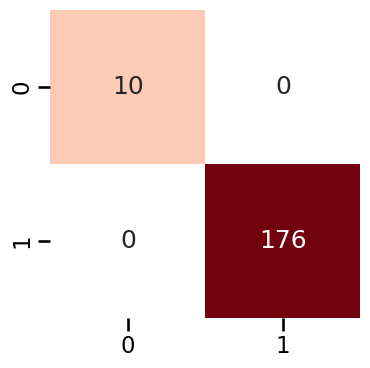

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00       176

    accuracy                           1.00       186
   macro avg       1.00      1.00      1.00       186
weighted avg       1.00      1.00      1.00       186

MCC Score:  1.0


<Figure size 640x480 with 0 Axes>

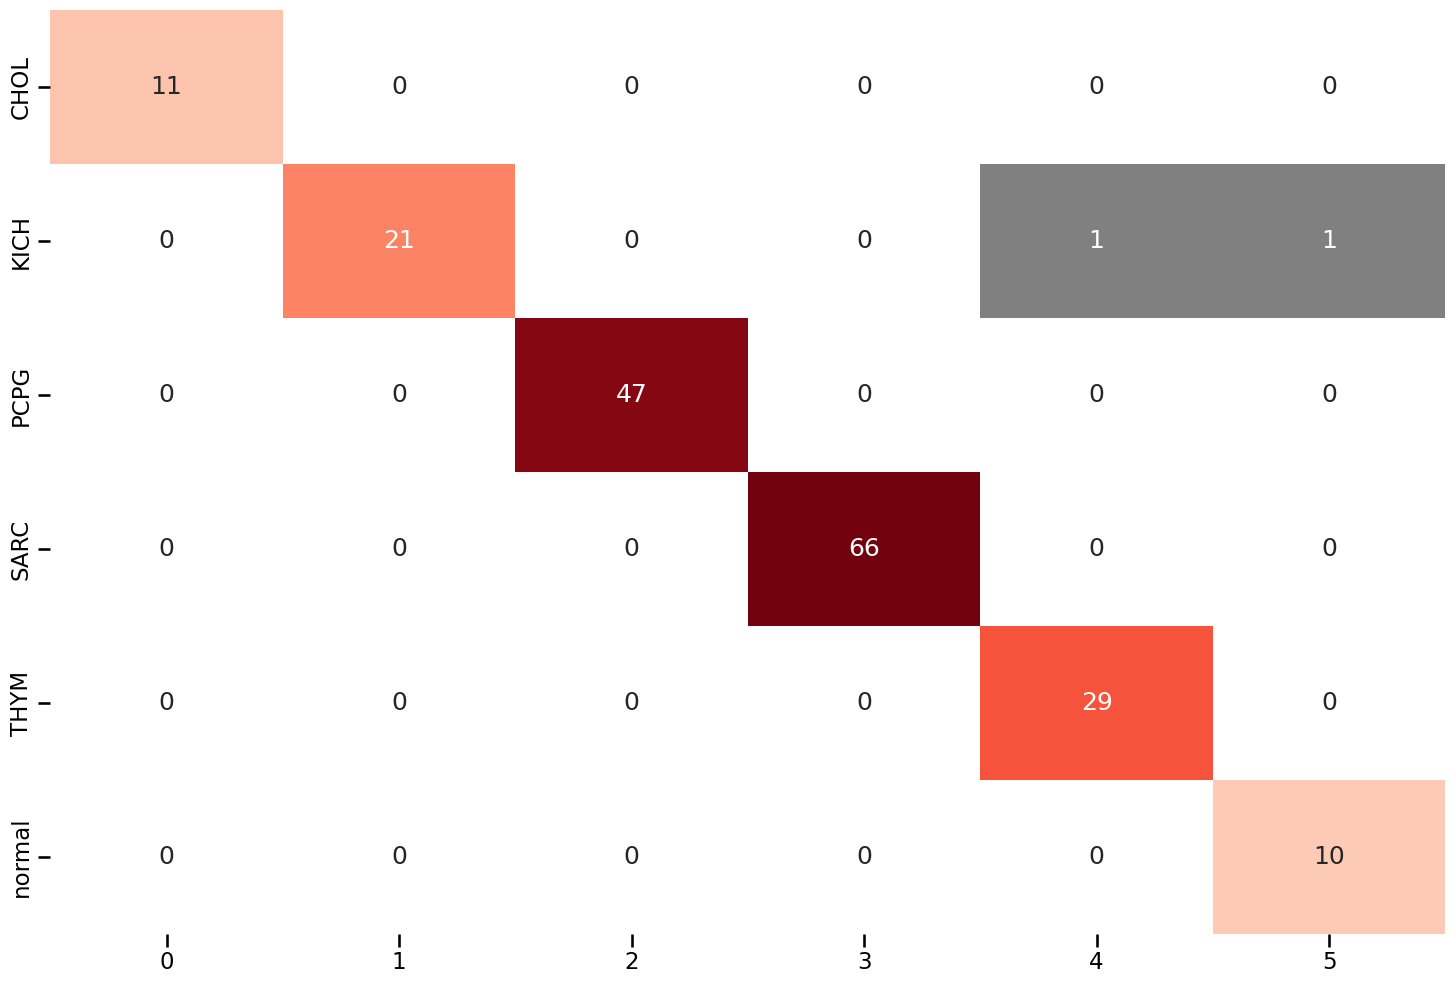

              precision    recall  f1-score   support

        CHOL       1.00      1.00      1.00        11
        KICH       1.00      0.91      0.95        23
        PCPG       1.00      1.00      1.00        47
        SARC       1.00      1.00      1.00        66
        THYM       0.97      1.00      0.98        29
      normal       0.91      1.00      0.95        10

    accuracy                           0.99       186
   macro avg       0.98      0.99      0.98       186
weighted avg       0.99      0.99      0.99       186

MCC Score:  0.9860459952467344


<Figure size 640x480 with 0 Axes>

In [22]:
# Classification
classification(homepath_rare, RandomForestClassifier(n_estimators=10), mode="binary", save_model="RF")
classification(homepath_rare, RandomForestClassifier(n_estimators=14), mode="multi", save_model="RF")

### Common Data

In [12]:
homepath_common = './common'
cancerpath_common = './common/cancer'
normalpath_common = './common/normal'

# Feature selection
names_common = featSelect(homepath_common,cancerpath_common,normalpath_common, k=5)

smoothed_cancer_common = './common/smoothed_cancer_magic'
smoothed_normal_common = './common/smoothed_normal_magic'

# Data process
dataProcess(homepath=homepath_common,
            names=names_common,
            cancerpath=cancerpath_common,
            smoothed_cancer=smoothed_cancer_common,
            smoothed_normal=smoothed_normal_common,
            scale_mode=0,
            cancer='BRCA')

# Upsample training data
upsampled(names_common, homepath_common)

# Merge data
binary_merge(names_common, homepath_common)
multi_merge(names_common, homepath_common)

Cancer files: ['BRCA.csv.gz', 'LUAD.csv.gz', 'COAD.csv.gz', 'LUSC.csv.gz', 'PRAD.csv.gz', 'UCEC.csv.gz', 'READ.csv.gz']
Normal files: ['LUAD.norm.csv.gz', 'READ.norm.csv.gz', 'UCEC.norm.csv.gz', 'COAD.norm.csv.gz', 'LUSC.norm.csv.gz', 'BRCA.norm.csv.gz', 'PRAD.norm.csv.gz']
Feature selection process is running...
Processing file index: 0
Doing feature selection for BRCA
Processing file index: 1
Doing feature selection for COAD
Processing file index: 2
Doing feature selection for LUAD
Processing file index: 3
Doing feature selection for LUSC
Processing file index: 4
Doing feature selection for PRAD
Processing file index: 5
Doing feature selection for READ
Processing file index: 6
Doing feature selection for UCEC
Feature selection process has ended

Data process is running
Unique genes: 35
BRCA
(1212, 35)
(112, 35)
COAD
(328, 35)
(26, 35)
LUAD
(576, 35)
(58, 35)
LUSC
(552, 35)
(51, 35)
PRAD
(550, 35)
(52, 35)
READ
(105, 35)
(6, 35)
UCEC
(201, 35)
(7, 35)
Data process has ended

Upsamplin

#### Cross-validation

In [13]:
# Load train data
X_bin_common, y_bin_common = load_data(homepath=homepath_common, classification_type="bin")
X_multi_common, y_multi_common = load_data(homepath=homepath_common, classification_type="multi")

Binary tuning

In [14]:
# Perform cv with optuna
cv_scores_bin_common, cv_params_bin_common, study_bin_common = perform_cv(X_bin_common, y_bin_common, classification_type='bin')

# Print CV scores and parameters
print("CV Scores:", cv_scores_bin_common)
print("CV Parameters:", cv_params_bin_common)

Generated Seeds: [103, 436, 861, 271, 107, 72, 701, 21, 615, 122]
Round 1


CV Progress (Round 1): 0it [00:00, ?it/s]

  Fold 1


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 1): 1it [00:31, 31.81s/it]

  Fold 2


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 1): 2it [01:05, 32.90s/it]

  Fold 3


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 1): 3it [01:37, 32.59s/it]

  Fold 4


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 1): 4it [02:10, 32.59s/it]

  Fold 5


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 1): 5it [02:43, 32.75s/it]


Round 2


CV Progress (Round 2): 0it [00:00, ?it/s]

  Fold 1


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 2): 1it [00:19, 19.35s/it]

  Fold 2


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 2): 2it [00:35, 17.31s/it]

  Fold 3


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 2): 3it [00:51, 16.67s/it]

  Fold 4


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 2): 4it [01:06, 16.08s/it]

  Fold 5


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 2): 5it [01:24, 16.92s/it]


Round 3


CV Progress (Round 3): 0it [00:00, ?it/s]

  Fold 1


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 3): 1it [00:29, 29.17s/it]

  Fold 2


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 3): 2it [00:58, 29.12s/it]

  Fold 3


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 3): 3it [01:28, 29.78s/it]

  Fold 4


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 3): 4it [01:57, 29.41s/it]

  Fold 5


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 3): 5it [02:27, 29.43s/it]


Round 4


CV Progress (Round 4): 0it [00:00, ?it/s]

  Fold 1


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 4): 1it [00:11, 11.44s/it]

  Fold 2


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 4): 2it [00:46, 25.43s/it]

  Fold 3


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 4): 3it [00:57, 18.79s/it]

  Fold 4


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 4): 4it [01:11, 16.81s/it]

  Fold 5


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 4): 5it [01:48, 21.63s/it]


Round 5


CV Progress (Round 5): 0it [00:00, ?it/s]

  Fold 1


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 5): 1it [00:11, 11.64s/it]

  Fold 2


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 5): 2it [00:21, 10.88s/it]

  Fold 3


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 5): 3it [00:43, 15.84s/it]

  Fold 4


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 5): 4it [00:53, 13.62s/it]

  Fold 5


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 5): 5it [01:03, 12.76s/it]


Round 6


CV Progress (Round 6): 0it [00:00, ?it/s]

  Fold 1


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 6): 1it [00:09,  9.76s/it]

  Fold 2


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 6): 2it [00:21, 10.80s/it]

  Fold 3


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 6): 3it [00:45, 16.80s/it]

  Fold 4


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 6): 4it [00:57, 15.06s/it]

  Fold 5


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 6): 5it [01:21, 16.37s/it]


Round 7


CV Progress (Round 7): 0it [00:00, ?it/s]

  Fold 1


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 7): 1it [00:28, 28.18s/it]

  Fold 2


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 7): 2it [01:00, 30.48s/it]

  Fold 3


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 7): 3it [01:24, 27.69s/it]

  Fold 4


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 7): 4it [01:50, 26.99s/it]

  Fold 5


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 7): 5it [02:30, 30.13s/it]


Round 8


CV Progress (Round 8): 0it [00:00, ?it/s]

  Fold 1


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 8): 1it [00:22, 22.22s/it]

  Fold 2


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 8): 2it [00:34, 16.15s/it]

  Fold 3


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 8): 3it [00:45, 13.86s/it]

  Fold 4


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 8): 4it [01:00, 14.26s/it]

  Fold 5


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 8): 5it [01:10, 14.01s/it]


Round 9


CV Progress (Round 9): 0it [00:00, ?it/s]

  Fold 1


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 9): 1it [00:13, 13.21s/it]

  Fold 2


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 9): 2it [00:27, 13.81s/it]

  Fold 3


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 9): 3it [00:38, 12.60s/it]

  Fold 4


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 9): 4it [00:56, 14.84s/it]

  Fold 5


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 9): 5it [01:07, 13.55s/it]


Round 10


CV Progress (Round 10): 0it [00:00, ?it/s]

  Fold 1


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 10): 1it [00:10, 10.21s/it]

  Fold 2


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 10): 2it [00:26, 13.71s/it]

  Fold 3


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 10): 3it [00:39, 13.42s/it]

  Fold 4


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 10): 4it [00:56, 14.68s/it]

  Fold 5


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 10): 5it [01:08, 13.76s/it]

CV Scores: {'accuracy': [0.9487908961593172, 0.9857954545454546, 0.875, 0.8735795454545454, 0.984375, 0.8991477272727273, 0.9730113636363636, 0.984375, 0.9857954545454546, 0.9487908961593172], 'mcc': [0.8695113943562062, 0.9626529219307172, 0.6441727695915408, 0.6423226307563823, 0.9598416608923539, 0.717326197415285, 0.9308352923773613, 0.9586299377917296, 0.9626529219307172, 0.8713899496298744], 'balanced_accuracy': [0.9477342695112072, 0.9820075757575757, 0.7784090909090909, 0.7869318181818181, 0.9876910613016474, 0.8239103429651633, 0.9763257575757576, 0.9820075757575757, 0.9838455306508236, 0.9460227272727273], 'f1_score': [0.9337459160593113, 0.9812022044687487, 0.8127093536489509, 0.8137538456965355, 0.9795114388293158, 0.8521214057697031, 0.9648642614166196, 0.9792838703636826, 0.9812022044687487, 0.9342047794347039], 'f2_score': [0.9424144310823311, 0.9823723561118771, 0.7891600715941646, 0.7958453198920059, 0.9854400091870332, 0.8335479624542125, 0.9715703195901294, 0.9809087

Multi-class tuning

In [15]:
# Perform cv with optuna
cv_scores_multi_common, cv_params_multi_common, study_multi_common = perform_cv(X_multi_common, y_multi_common, classification_type='multi')

# Print CV scores and parameters
print("CV Scores:", cv_scores_multi_common)
print("CV Parameters:", cv_params_multi_common)

Generated Seeds: [103, 436, 861, 271, 107, 72, 701, 21, 615, 122]
Round 1


CV Progress (Round 1): 0it [00:00, ?it/s]

  Fold 1


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 1): 1it [00:36, 36.84s/it]

  Fold 2


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 1): 2it [01:13, 36.54s/it]

  Fold 3


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 1): 3it [01:49, 36.47s/it]

  Fold 4


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 1): 4it [02:26, 36.55s/it]

  Fold 5


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 1): 5it [03:02, 36.48s/it]


Round 2


CV Progress (Round 2): 0it [00:00, ?it/s]

  Fold 1


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 2): 1it [00:18, 18.39s/it]

  Fold 2


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 2): 2it [00:44, 23.21s/it]

  Fold 3


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 2): 3it [01:02, 20.81s/it]

  Fold 4


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 2): 4it [01:21, 20.08s/it]

  Fold 5


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 2): 5it [01:40, 20.07s/it]


Round 3


CV Progress (Round 3): 0it [00:00, ?it/s]

  Fold 1


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 3): 1it [00:33, 33.59s/it]

  Fold 2


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 3): 2it [01:05, 32.85s/it]

  Fold 3


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 3): 3it [01:24, 26.50s/it]

  Fold 4


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 3): 4it [01:45, 24.26s/it]

  Fold 5


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 3): 5it [02:07, 25.49s/it]


Round 4


CV Progress (Round 4): 0it [00:00, ?it/s]

  Fold 1


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 4): 1it [00:16, 16.59s/it]

  Fold 2


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 4): 2it [00:29, 14.55s/it]

  Fold 3


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 4): 3it [00:42, 13.75s/it]

  Fold 4


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 4): 4it [01:20, 23.33s/it]

  Fold 5


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 4): 5it [01:34, 18.91s/it]


Round 5


CV Progress (Round 5): 0it [00:00, ?it/s]

  Fold 1


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 5): 1it [00:12, 12.83s/it]

  Fold 2


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 5): 2it [00:28, 14.29s/it]

  Fold 3


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 5): 3it [00:41, 14.01s/it]

  Fold 4


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 5): 4it [00:53, 13.05s/it]

  Fold 5


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 5): 5it [01:06, 13.38s/it]


Round 6


CV Progress (Round 6): 0it [00:00, ?it/s]

  Fold 1


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 6): 1it [00:30, 30.58s/it]

  Fold 2


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 6): 2it [00:44, 20.56s/it]

  Fold 3


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 6): 3it [01:06, 21.47s/it]

  Fold 4


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 6): 4it [01:20, 18.50s/it]

  Fold 5


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 6): 5it [01:32, 18.47s/it]


Round 7


CV Progress (Round 7): 0it [00:00, ?it/s]

  Fold 1


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 7): 1it [00:21, 21.61s/it]

  Fold 2


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 7): 2it [00:51, 26.32s/it]

  Fold 3


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 7): 3it [01:25, 30.11s/it]

  Fold 4


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 7): 4it [02:03, 33.24s/it]

  Fold 5


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 7): 5it [02:38, 31.75s/it]


Round 8


CV Progress (Round 8): 0it [00:00, ?it/s]

  Fold 1


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 8): 1it [00:34, 34.66s/it]

  Fold 2


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 8): 2it [01:09, 34.48s/it]

  Fold 3


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 8): 3it [01:34, 30.46s/it]

  Fold 4


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 8): 4it [02:09, 32.12s/it]

  Fold 5


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 8): 5it [02:43, 32.80s/it]


Round 9


CV Progress (Round 9): 0it [00:00, ?it/s]

  Fold 1


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 9): 1it [00:14, 14.38s/it]

  Fold 2


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 9): 2it [00:34, 17.87s/it]

  Fold 3


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 9): 3it [00:48, 15.85s/it]

  Fold 4


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 9): 4it [01:11, 18.98s/it]

  Fold 5


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 9): 5it [01:35, 19.18s/it]


Round 10


CV Progress (Round 10): 0it [00:00, ?it/s]

  Fold 1


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 10): 1it [00:18, 18.93s/it]

  Fold 2


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 10): 2it [00:37, 18.82s/it]

  Fold 3


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 10): 3it [01:08, 24.09s/it]

  Fold 4


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 10): 4it [01:22, 20.27s/it]

  Fold 5


  0%|          | 0/25 [00:00<?, ?it/s]

CV Progress (Round 10): 5it [01:41, 20.29s/it]

CV Scores: {'accuracy': [0.90625, 0.9743954480796586, 0.6856330014224751, 0.9345661450924608, 0.9744318181818182, 0.6946022727272727, 0.6813655761024182, 0.8977272727272727, 0.887624466571835, 0.7471590909090909], 'mcc': [0.8870927540986453, 0.9688712120667414, 0.6335479862634193, 0.9210285769983941, 0.968921121279954, 0.6428763527034935, 0.6266615742442664, 0.8763795259575268, 0.8644913849730278, 0.6961565309203317], 'balanced_accuracy': [0.787351532118548, 0.9336829487274789, 0.5019837434510412, 0.8499870462727662, 0.9410744113578635, 0.51289307130886, 0.49914687428351845, 0.7783800671875463, 0.7735650888950572, 0.5668433608767152], 'f1_score': [0.7930387533609784, 0.9482994868460699, 0.47266830116401937, 0.8801845814649953, 0.9554388811454313, 0.481413878925432, 0.47080291555703957, 0.7798746825047693, 0.7766161543557359, 0.5675286085578994], 'f2_score': [0.7894099529452888, 0.9378329271011896, 0.4848473794323515, 0.8597793829586285, 0.9463080288408674, 0.49535371235979275, 0.482753

Best parameters

In [16]:
study_bin_common.best_params

{'n_estimators': 11, 'max_depth': 5}

In [17]:
study_multi_common.best_params

{'n_estimators': 39, 'max_depth': 2}

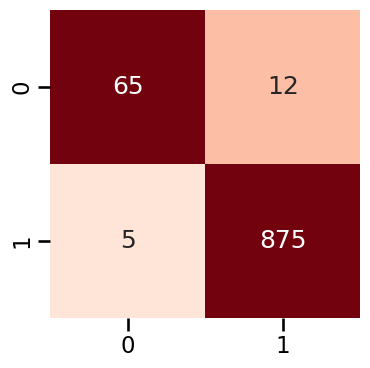

              precision    recall  f1-score   support

           0       0.93      0.84      0.88        77
           1       0.99      0.99      0.99       880

    accuracy                           0.98       957
   macro avg       0.96      0.92      0.94       957
weighted avg       0.98      0.98      0.98       957

MCC Score:  0.8759220968907322


<Figure size 640x480 with 0 Axes>

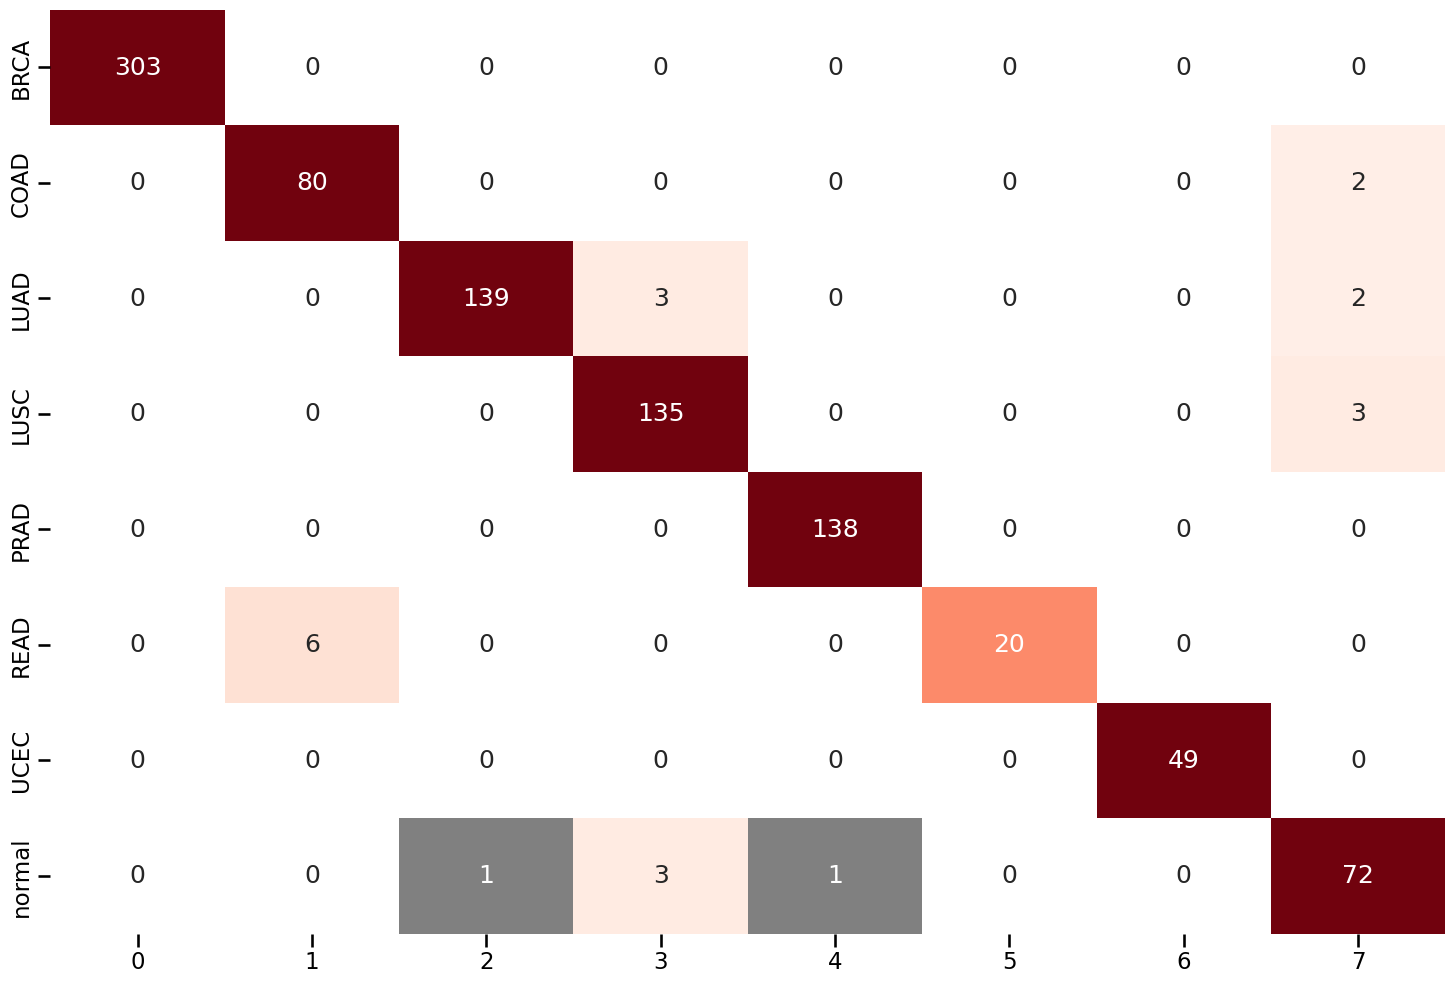

              precision    recall  f1-score   support

        BRCA       1.00      1.00      1.00       303
        COAD       0.93      0.98      0.95        82
        LUAD       0.99      0.97      0.98       144
        LUSC       0.96      0.98      0.97       138
        PRAD       0.99      1.00      1.00       138
        READ       1.00      0.77      0.87        26
        UCEC       1.00      1.00      1.00        49
      normal       0.91      0.94      0.92        77

    accuracy                           0.98       957
   macro avg       0.97      0.95      0.96       957
weighted avg       0.98      0.98      0.98       957

MCC Score:  0.9732281772908618


<Figure size 640x480 with 0 Axes>

In [20]:
# Classification
classification(homepath_common, RandomForestClassifier(n_estimators=11), mode="binary", save_model="RF")
classification(homepath_common, RandomForestClassifier(n_estimators=39), mode="multi", save_model="RF")